In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
np.random.seed(42)

%matplotlib inline

plt.rcParams['figure.figsize'] = (10,6)

### Plot the objective function

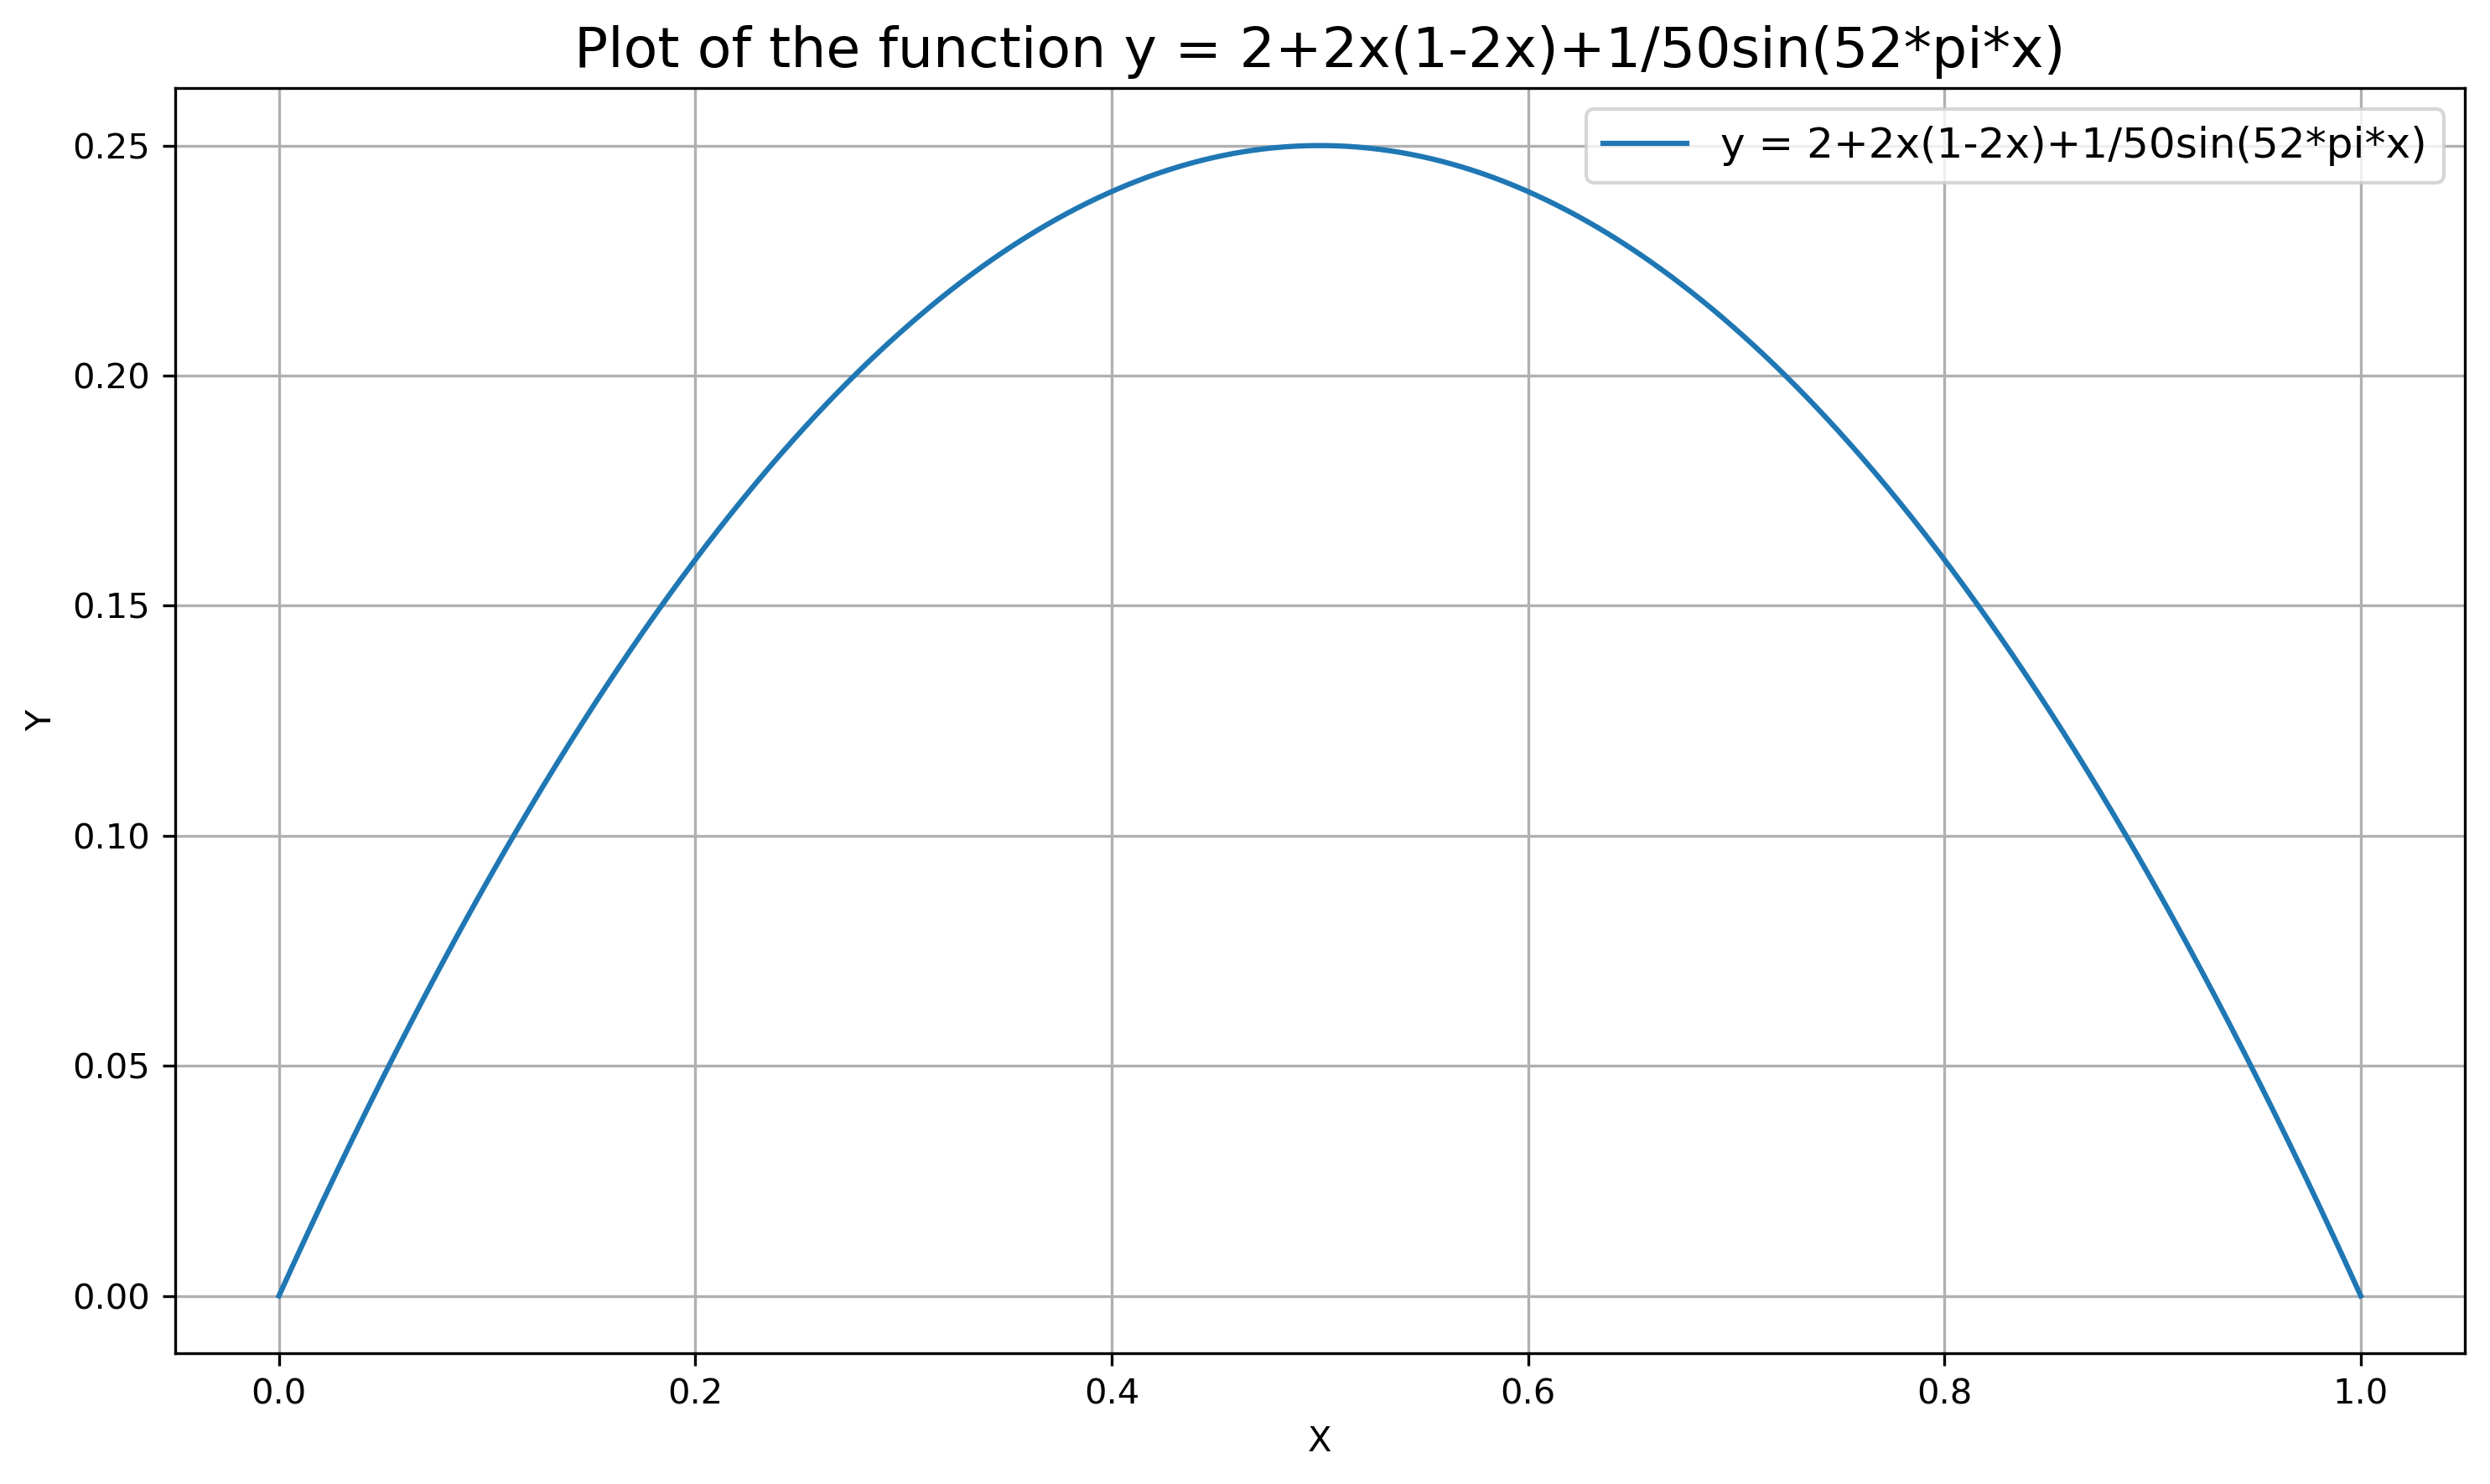

In [2]:
fig, ax = plt.subplots(dpi=300)
x_values = np.linspace(0, 1, 1000)  # Generating 100 points between 0 and 1
f_values = x_values * (1 - x_values)  # Computing x(1-x) for each x
# f_values = 2 + 2*x_values*(1-2*x_values) + 1/50*np.sin(52*np.pi*x_values)

ax.plot(x_values, f_values, label='y = 2+2x(1-2x)+1/50sin(52*pi*x)')
ax.set_title('Plot of the function y = 2+2x(1-2x)+1/50sin(52*pi*x)', fontsize=16)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()

### Thompson Sampling

In [194]:
def uniform(k):
    global xp
    if k >= len(xp):
        raise ValueError("Index out of range")
    return np.random.uniform(xp[k], xp[k + 1])


def payout_f1(x, noise=True):
    if noise == False:
        return x * (1-x)
    return x * (1-x) + (1-x)**2 * np.random.randn()

def payout_f2(x, noise=True):
    psi = 2 + 2*x*(1-2*x) + 1/50*np.sin(52*np.pi*x)
    if noise == False:
        return psi
    else:
        return psi + 0.05 * np.random.randn()

def thompson_step(N, mu, mu2, payout_f, noise=True):

    # select an action
    # find the action which has been the least tried
    idx_min = np.argmin(N)
    N_min = N[idx_min,0]

    if N_min < 12:
        a = idx_min
    else:
        sig = mu2 - mu**2
        a = np.argmax(mu + sig * np.random.randn(len(mu), 1))

    x = uniform(a)
    y = payout_f(x, noise=noise)
    # updates statistics
    N[a,0] = N[a,0] + 1
    mu[a,0] = mu[a,0] + (y-mu[a,0])/N[a,0]
    mu2[a,0] = mu2[a,0] + (y*y - mu2[a,0]) / N[a,0]

    return a, x, y

def plot_hist(xp, P, payout_f, label):
    x_values = np.linspace(0, 1, 1000)
    f_values = payout_f(x_values, noise=False)
    _, ax = plt.subplots(dpi=300)
    ax.bar(xp[:-1], P.flatten(), width=np.diff(xp), align='edge', color = 'darkturquoise' ,edgecolor='black')
    ax.plot(x_values, f_values, label=label)
    ax.set_xlabel('Partitions', fontsize=12)
    ax.set_ylabel('Probability/Function Value', fontsize=12)
    ax.set_title(f'{label} with noise', fontsize=16)
    ax.legend(fontsize=12)
    plt.show()

In [195]:
quant = np.linspace(0, 1, 17)
xp = quant
d = len(xp) - 1
nlap = 1
Nit = 1000000
a = np.full((Nit, nlap), np.nan)
x = np.full((Nit, nlap), np.nan)
y = np.full((Nit, nlap), np.nan)
# e = np.full((Nit, nlap), np.nan)
N = np.zeros((d,1))
mu = np.zeros((d,1))
mu2 = np.zeros((d,1))

H0 = 0.5*np.log(d)
# f_label = 'F(x) = x(1-x)'
f_label = 'F(x) = 2+2x(1-2x)+1/50sin(52*pi*x)'
print (f'Target entropy is : {H0}')

Target entropy is : 1.3862943611198906


In [199]:
np.max(P)

0.33438080919999996

In [198]:
mu[np.argmax(P)]

array([2.24824892])

---Begin Time: 5000---
---Begin Time: 10000---
---Begin Time: 15000---
---Begin Time: 20000---
---Begin Time: 25000---
---Begin Time: 30000---
---Begin Time: 35000---
---Begin Time: 40000---
---Begin Time: 45000---
---Begin Time: 50000---
---Begin Time: 55000---
---Begin Time: 60000---
---Begin Time: 65000---
---Begin Time: 70000---
---Begin Time: 75000---
---Begin Time: 80000---
---Begin Time: 85000---
---Begin Time: 90000---
---Begin Time: 95000---
---Begin Time: 100000---
---Begin Time: 105000---
---Begin Time: 110000---
---Begin Time: 115000---
---Begin Time: 120000---
---Begin Time: 125000---
---Begin Time: 130000---
---Begin Time: 135000---
---Begin Time: 140000---
---Begin Time: 145000---
---Begin Time: 150000---
---Begin Time: 155000---
---Begin Time: 160000---
---Begin Time: 165000---
---Begin Time: 170000---
---Begin Time: 175000---
---Begin Time: 180000---
---Begin Time: 185000---
---Begin Time: 190000---
---Begin Time: 195000---
---Begin Time: 200000---
---Begin Time: 20500

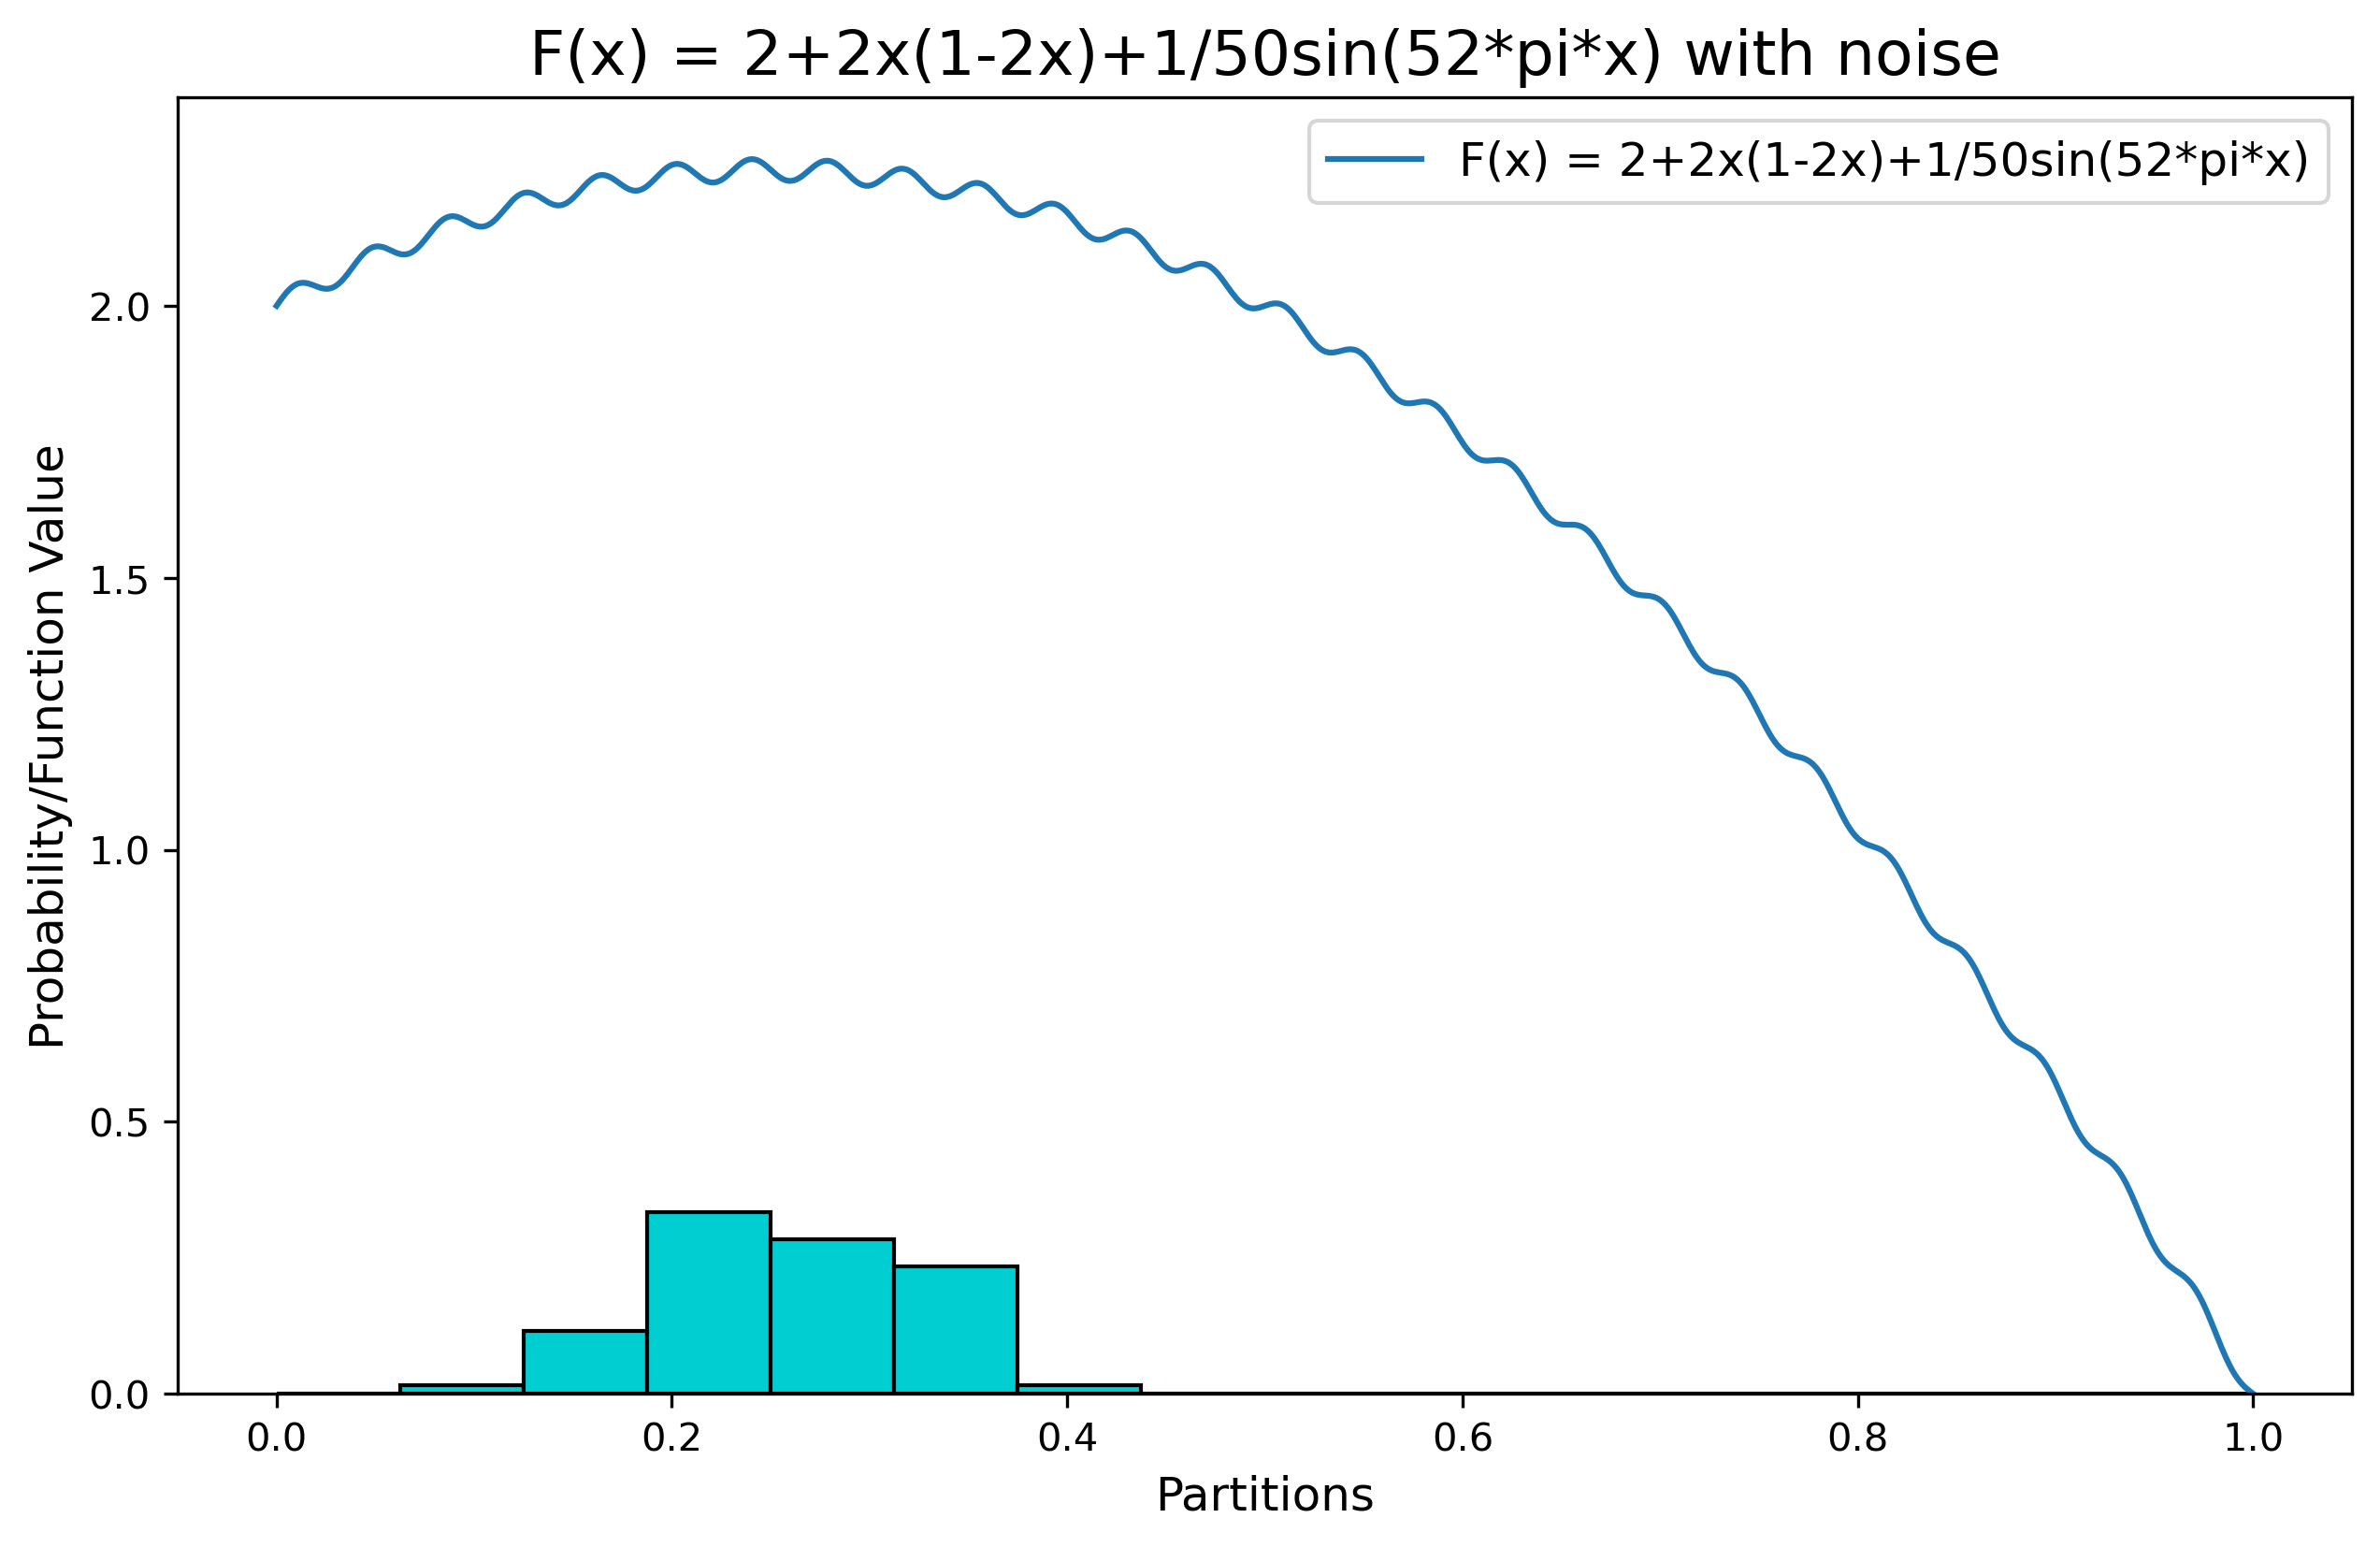

1.4459637350401569


In [196]:
e_list = []
for lap in range(nlap):
    for t in range(Nit):
        at, xt, yt = thompson_step(N, mu, mu2, payout_f2, noise=True)
        a[t,lap] = at
        x[t,lap] = xt
        y[t,lap] = yt
    
        if t > 500 and t%5000 == 0:
            print (f'---Begin Time: {t}---')
            P = np.zeros((len(N), 1))
            ind = np.argmax(mu + np.sqrt(mu2 - mu**2) * np.random.randn(len(mu), int(1e6)), axis=0)
            w = np.array(np.unique(ind, return_counts=True)).T
            for index, count in w:
                P[int(index)] = count / int(1e6) 
            P = P + 0.0001 * (np.ones((d,1)) / d - P) # Regularize P

            et = np.sum(P[P > 0] * np.log(1/P[P > 0]))
            e_list.append(et)
   
    plot_hist(xp, P, payout_f2, label=f_label )
    
    print(et)
    # If we have reduced the entropy enough then get a new partition
    if et < H0:
       
        xp = interp1d(np.concatenate(([0], np.cumsum(P[:-1]), [1])), xp, kind='linear')(quant)

        N = np.zeros((d,1))
        mu = np.zeros((d,1))
        mu2 = np.zeros((d,1))



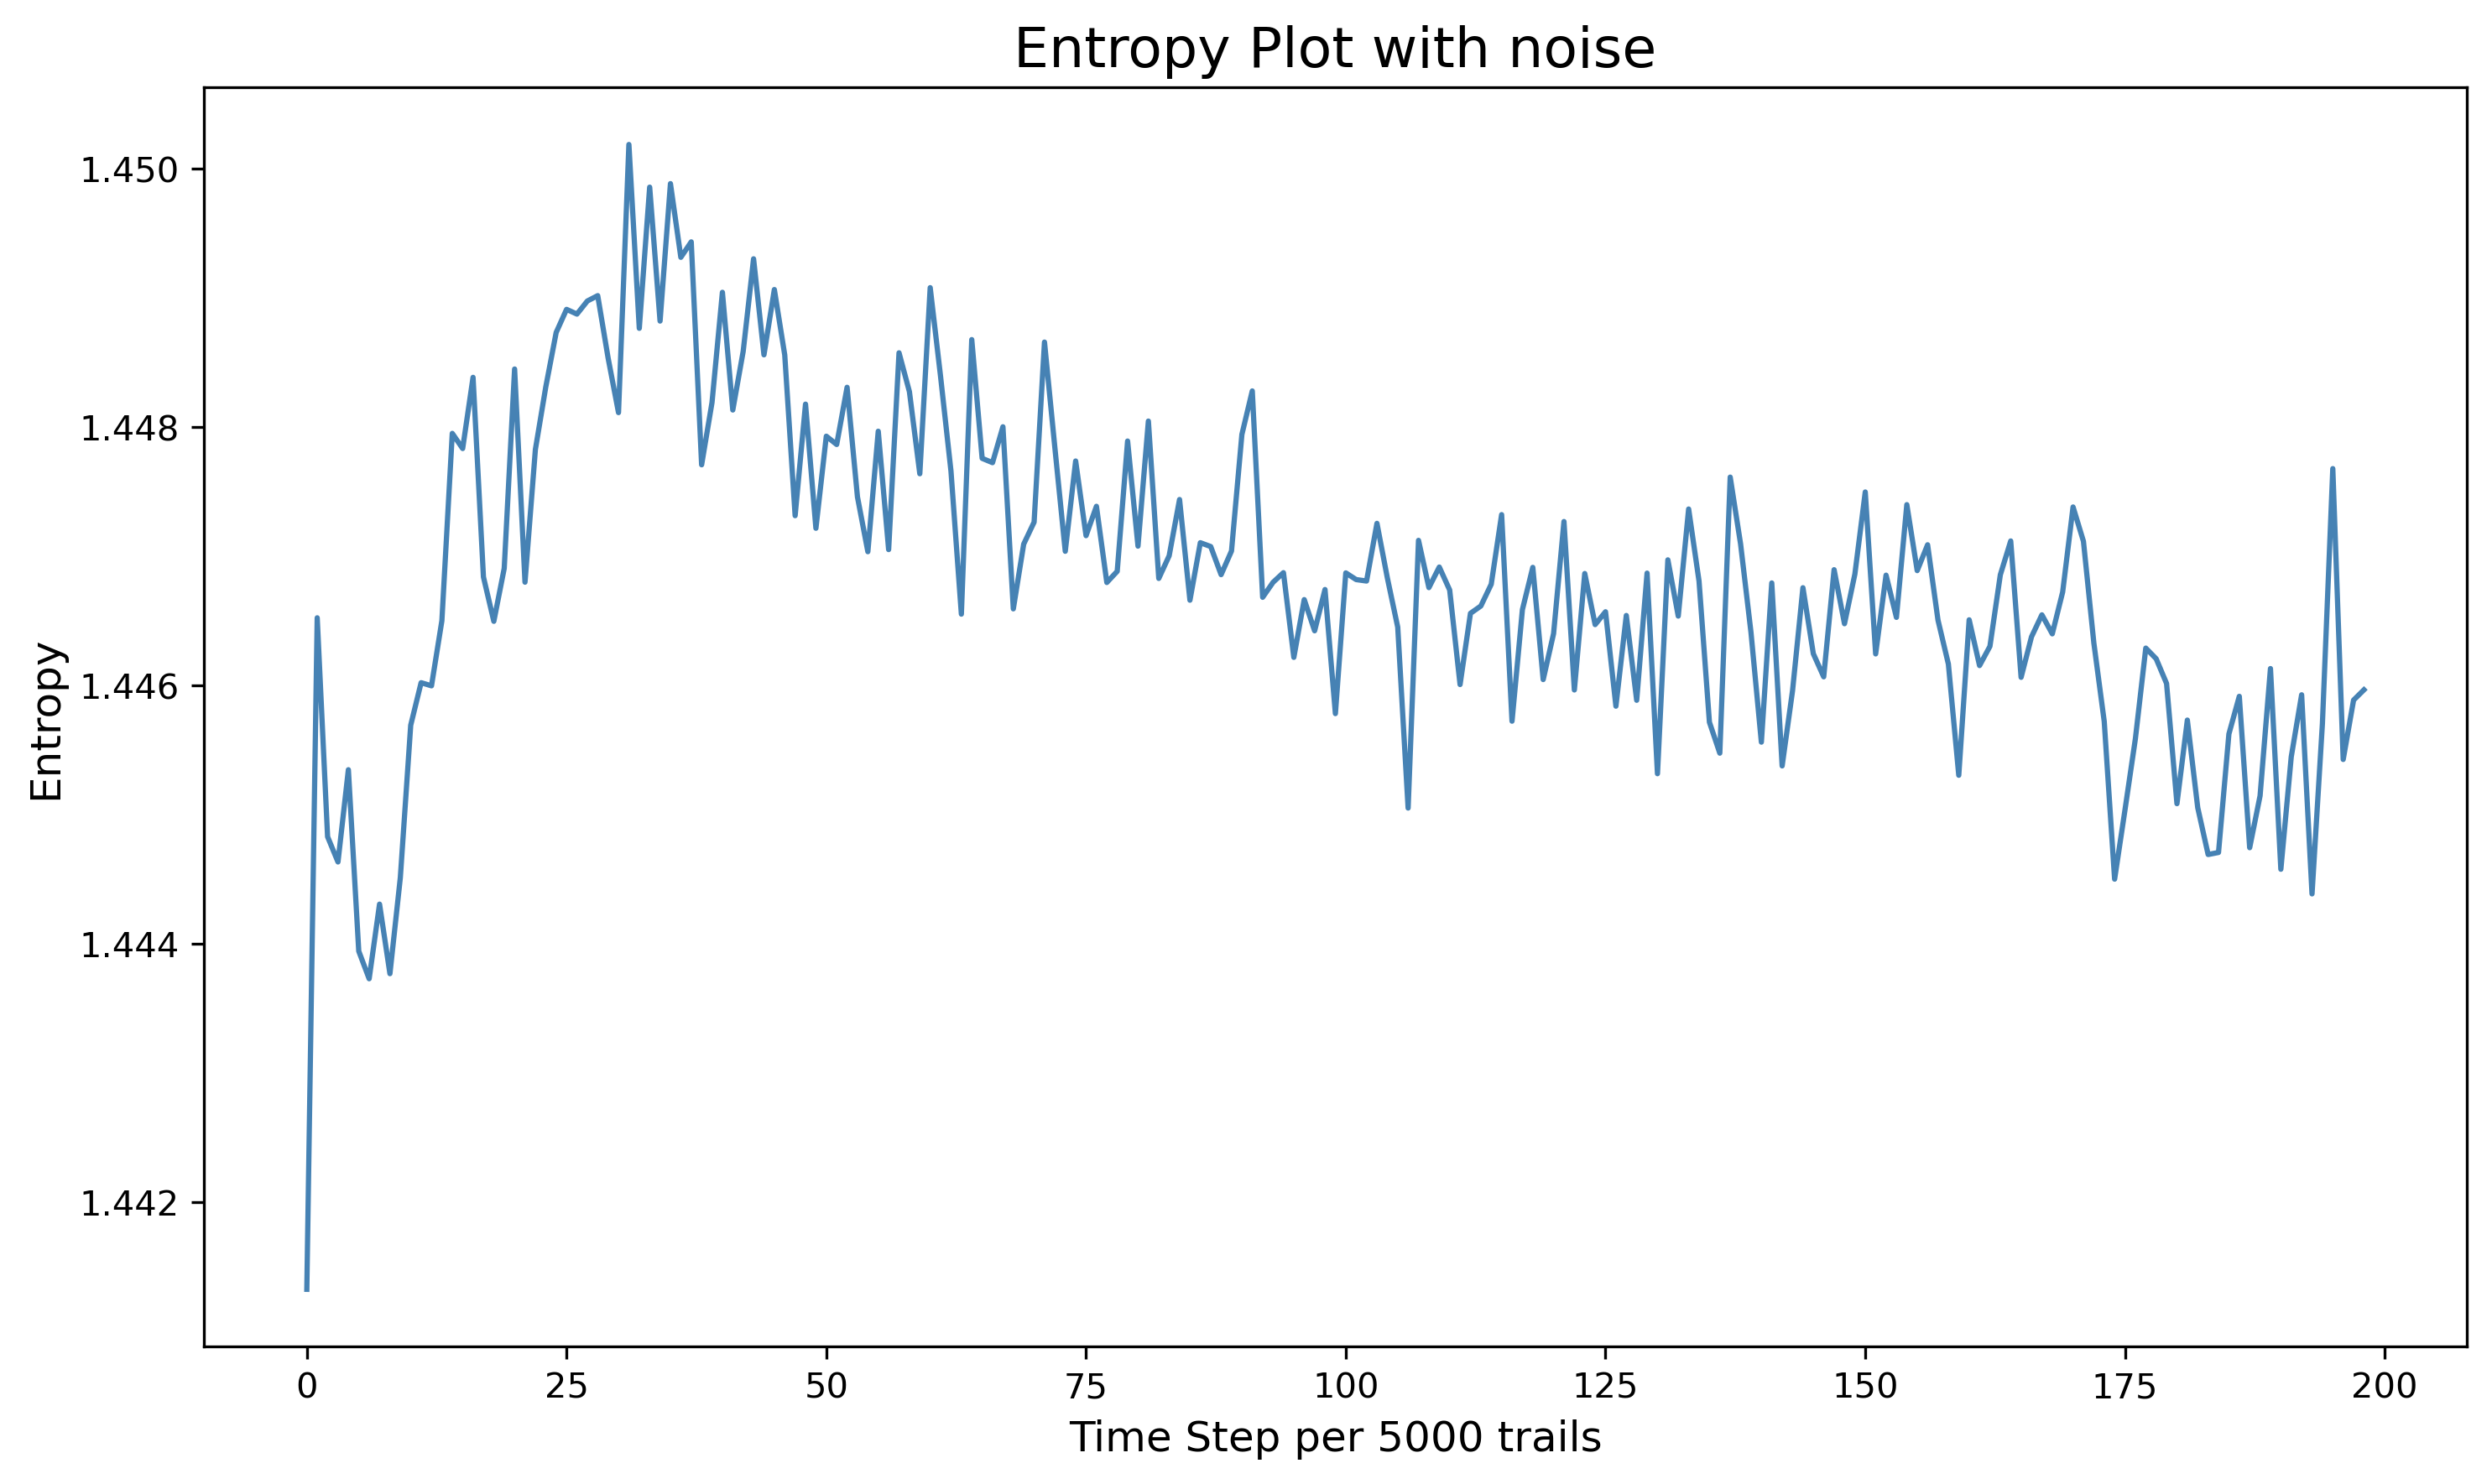

In [197]:
fig, ax = plt.subplots(dpi=300)
ax.plot(e_list, color='steelblue')
# ax.plot(e_list, color='lightseagreen')
ax.set_xlabel("Time Step per 5000 trails", fontsize=12)
ax.set_ylabel("Entropy", fontsize=12)
ax.set_title("Entropy Plot with noise", fontsize=16)
plt.tight_layout()

In [177]:
sample_y = y.T[0]
sample_x = x.T[0]

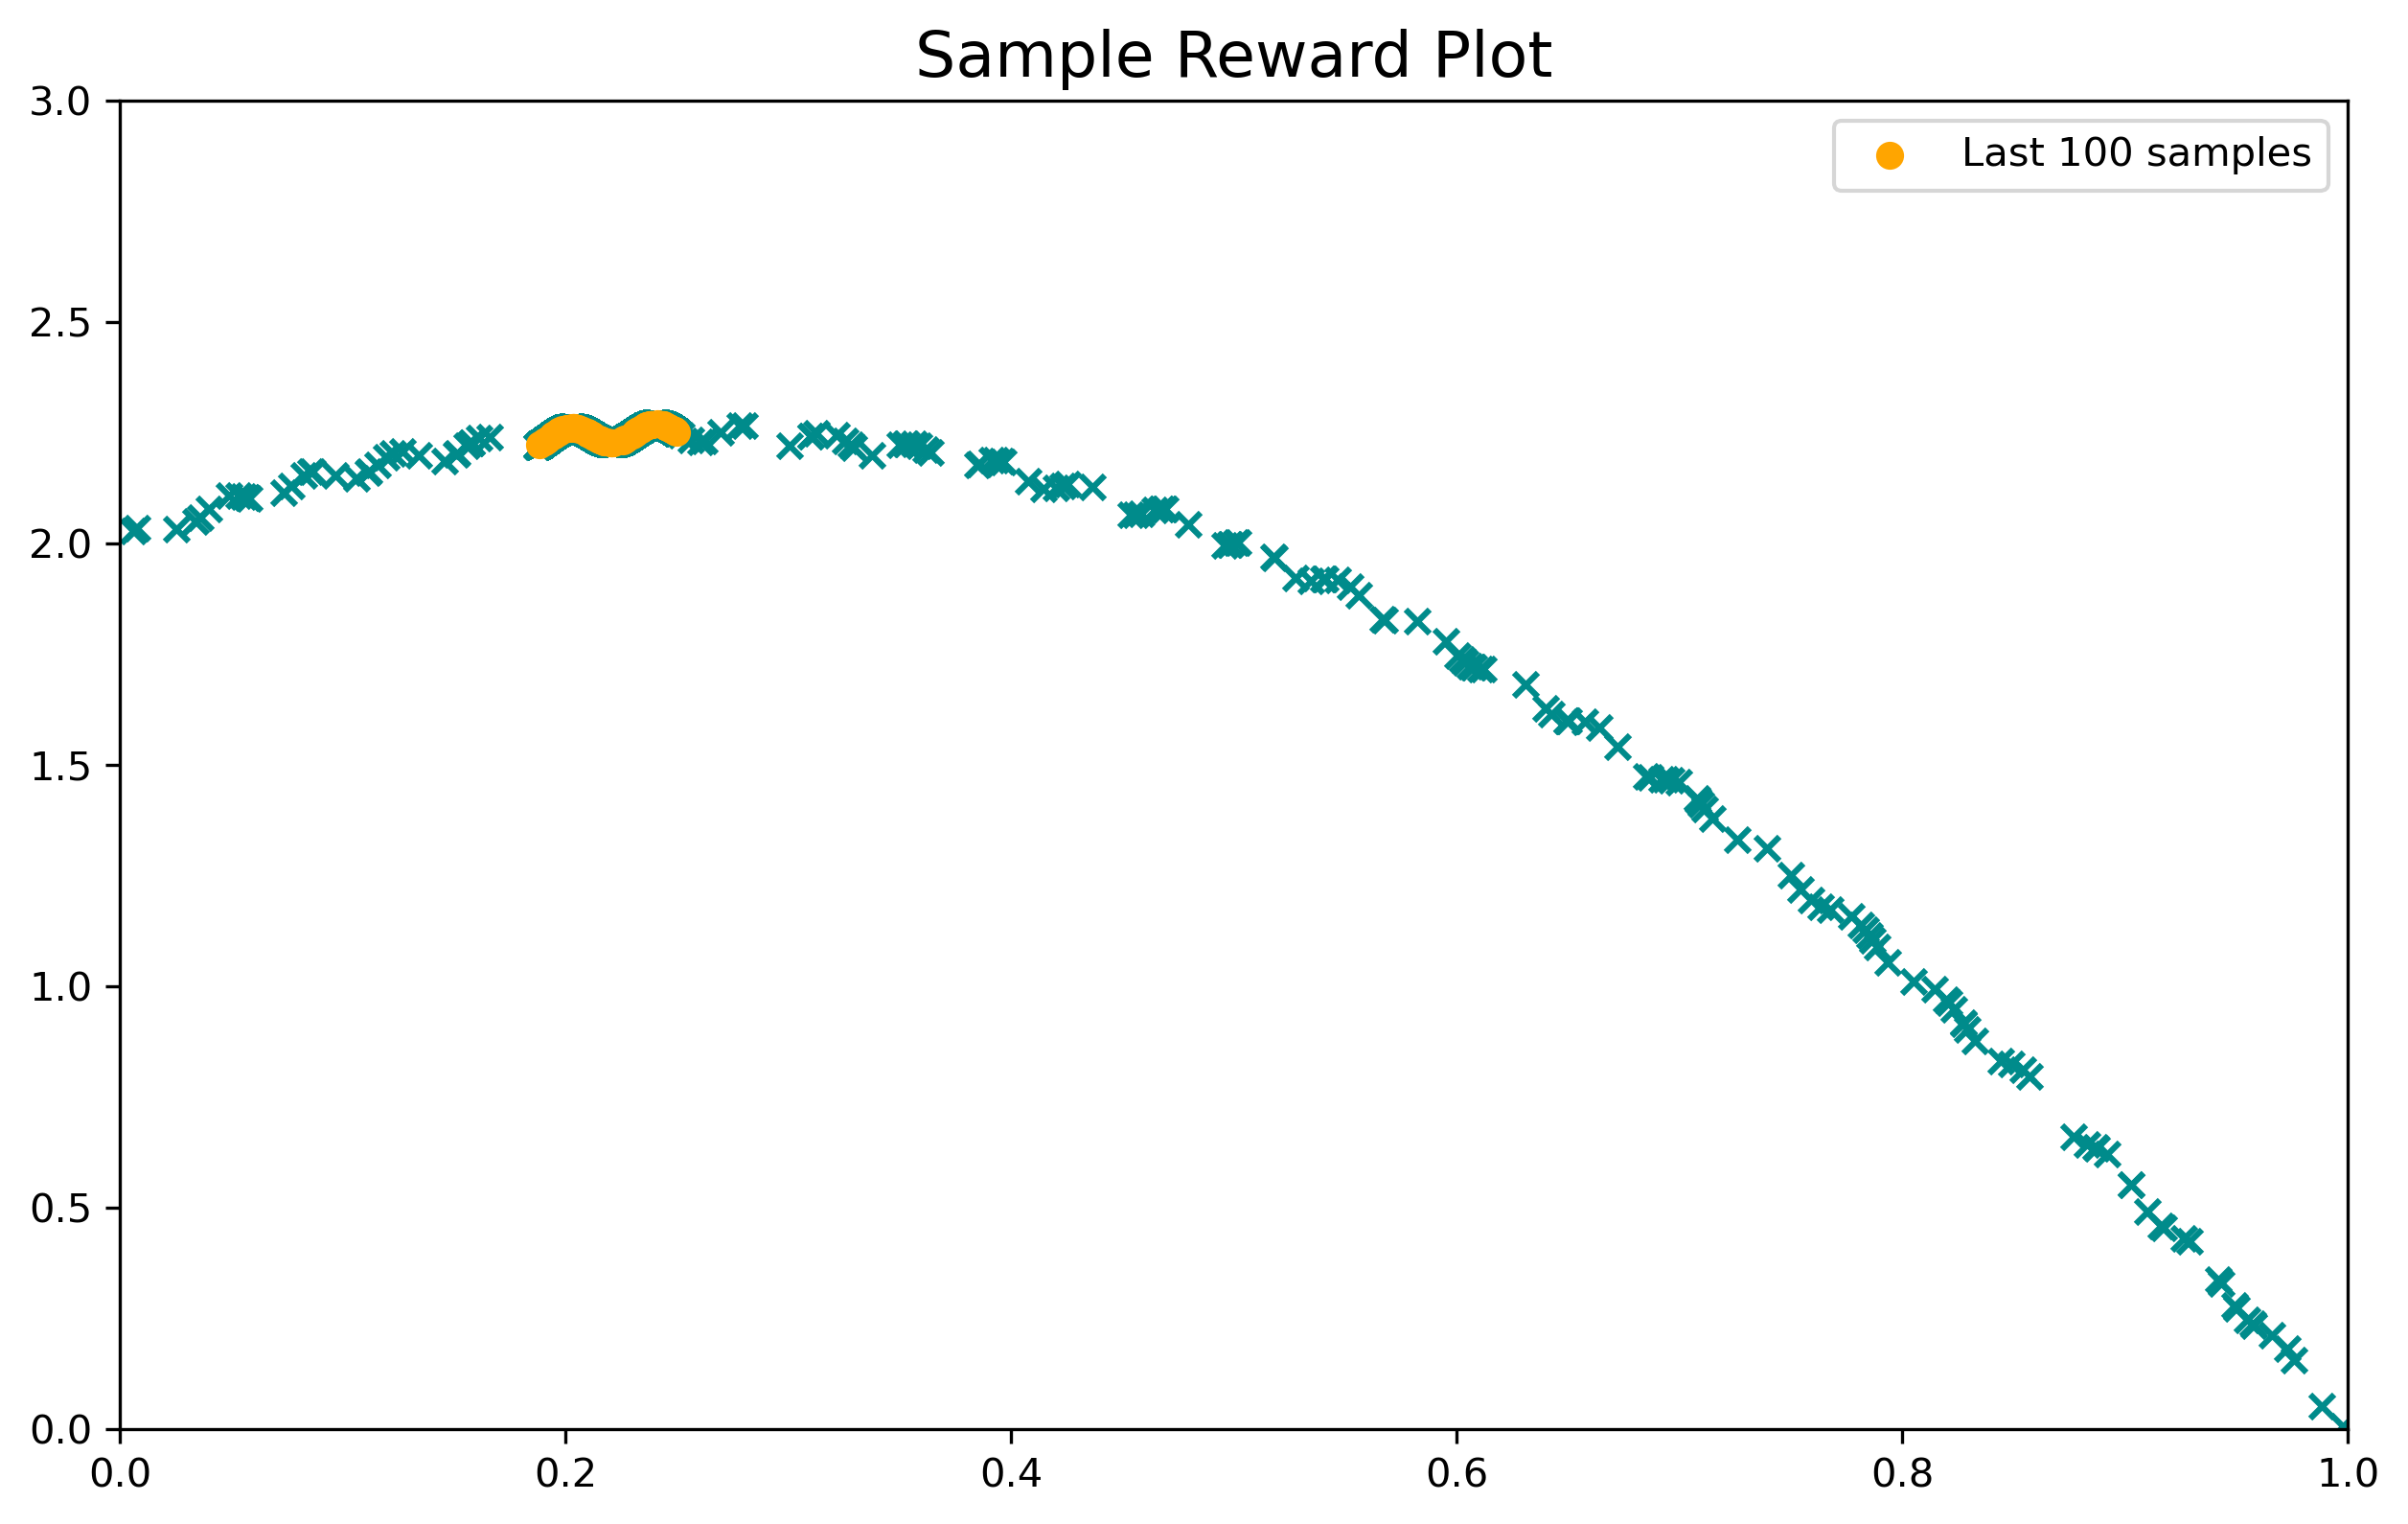

In [178]:
fig, ax = plt.subplots(dpi=300)
ax.scatter(sample_x, sample_y, color='darkcyan', marker='x')
ax.scatter(sample_x[-100:], sample_y[-100:], color='orange', label='Last 100 samples')
ax.set_title('Sample Reward Plot', fontsize=16)
ax.legend()
plt.ylim(0,3)
plt.xlim(0, 1)
plt.show()